# Hello
I would like to present my very first data science project. Please do not be intimidated by its magnificence.
This is a simple food recommendation project. It gives ideas of dishes basing on your favourite food.
This is first project version, which works on a "dead" dataset. In other version the project will base on API and connect with website to search for recipes.

## Libraries and knowledge

In [40]:
import os
import numpy as np # linear algebra and arrays
import pandas as pd # dataframes and stuff
import matplotlib.pyplot as plt # plots
%matplotlib inline
import seaborn as sns # more plots
import statistics as st # distributions
import scipy as sp # pivot engineering

#ML model
from sklearn.metrics.pairwise import cosine_similarity

## Data import and first glimpse into it

### Users
u - UserID
techniques - Cooking techniques encountered by user
items - Recipes interacted with, in order
n_items - Number of recipes reviewed
ratings - Ratings given to each recipe encountered by this user
n_ratings - Number of ratings in total

In [3]:
users_pp = pd.read_csv('archive/PP_users.csv')
users_pp.info()
users_pp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25076 entries, 0 to 25075
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   u           25076 non-null  int64 
 1   techniques  25076 non-null  object
 2   items       25076 non-null  object
 3   n_items     25076 non-null  int64 
 4   ratings     25076 non-null  object
 5   n_ratings   25076 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.1+ MB


,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376


### Recipes - preprocessed data
id - Recipe ID
i - Recipe ID mapped to contiguous integers from 0
name_tokens - BPE-tokenized recipe name
ingredient_tokens - BPE-tokenized ingredients list (list of lists)
steps_tokens - BPE-tokenized steps
techniques - List of techniques used in recipe
calorie_level - Calorie level in ascending order
ingredients_ids - IDs of ingredients in recipe

In [4]:
recipes_pp = pd.read_csv('archive/PP_recipes.csv')
recipes_pp.info()
recipes_pp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178265 entries, 0 to 178264
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 178265 non-null  int64 
 1   i                  178265 non-null  int64 
 2   name_tokens        178265 non-null  object
 3   ingredient_tokens  178265 non-null  object
 4   steps_tokens       178265 non-null  object
 5   techniques         178265 non-null  object
 6   calorie_level      178265 non-null  int64 
 7   ingredient_ids     178265 non-null  object
dtypes: int64(3), object(5)
memory usage: 10.9+ MB


,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


### Recipes - raw data
name - Recipe name
id - Recipe ID
minutes - Minutes to prepare recipe
contributor_id - User ID who submitted this recipe
submitted - Date recipe was submitted
tags - Food.com tags for recipe
nutrition - Nutrition information (calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat
steps - Text for recipe steps, in order
description - User-provided description

In [5]:
recipes_raw = pd.read_csv('archive/RAW_recipes.csv')
recipes_raw.info()
recipes_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


### Interactions
user_id - User ID
recipe_id - Recipe ID
date - Date of interaction
rating - Rating given
review - Review text

In [6]:
interactions_raw = pd.read_csv('archive/RAW_interactions.csv')
interactions_raw.info()
interactions_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


## Data analysis

### Most often rated recipes

I am gonna do it using lists, where list indexes will be recipe ids. This requires creating lists longer by one than maximum recipe_id, so that recipe_id can directly match list index.
Having it done I will create a structured array as in formula:
[(recipe_id, interactions_count, average_rating), ...]

In [7]:
# Create lists for interactions count and sum of rates
interactions_count = [0] * (max(recipes_raw['id'].values) + 1)
ratings_sum = [0] * (max(recipes_raw['id'].values) + 1)

# Fill the lists
for row_index, row in interactions_raw.iterrows():
    recipe_id = interactions_raw.loc[row_index]['recipe_id']
    rating = interactions_raw.loc[row_index]['rating']
    interactions_count[recipe_id] += 1
    ratings_sum[recipe_id] += rating

In [8]:
# Create a structured array to store the recipes stats
array_structure = [('recipe_id', int), ('interactions_count', int), ('avg_rating', float)]
array_values = []

for recipe_id in recipes_raw['id'].values:
    interactions_number = interactions_count[recipe_id]
    avg_rating = ratings_sum[recipe_id] / interactions_count[recipe_id]
    array_values.append((recipe_id, interactions_number, avg_rating))
recipe_stats = np.array(array_values, dtype = array_structure)

In [15]:
# Find 10 most often rated recipes
most_often_recipes = recipe_stats.copy()
most_often_recipes.sort(order = 'interactions_count')
most_often_recipes = most_often_recipes[::-1]

for i in range(10, 0, -1):
    print('Position ', i, ':', sep = '')
    recipe_id = most_often_recipes[i - 1]['recipe_id']
    name = recipes_raw.loc[recipes_raw['id'] == recipe_id]['name'].to_string(index= False)
    print(name.upper())
    print('Interactions:  ', most_often_recipes[i - 1]['interactions_count'])
    avg_rating = most_often_recipes[i - 1]['avg_rating']
    print(f'Average rating: {avg_rating:1.2f} / 5\n')

Position 10:
JAPANESE MUM S CHICKEN
Interactions:   904
Average rating: 4.40 / 5

Position 9:
KITTENCAL S ITALIAN MELT IN YOUR MOUTH MEATBALLS
Interactions:   997
Average rating: 4.71 / 5

Position 8:
WHATEVER FLOATS YOUR BOAT  BROWNIES
Interactions:   1220
Average rating: 4.53 / 5

Position 7:
JO MAMA S WORLD FAMOUS SPAGHETTI
Interactions:   1234
Average rating: 4.42 / 5

Position 6:
YES  VIRGINIA THERE IS A GREAT MEATLOAF
Interactions:   1305
Average rating: 4.21 / 5

Position 5:
BEST EVER BANANA CAKE WITH CREAM CHEESE FROSTING
Interactions:   1322
Average rating: 4.33 / 5

Position 4:
CREAMY CAJUN CHICKEN PASTA
Interactions:   1448
Average rating: 4.54 / 5

Position 3:
CROCK POT CHICKEN WITH BLACK BEANS   CREAM CHEESE
Interactions:   1579
Average rating: 4.22 / 5

Position 2:
TO DIE FOR CROCK POT ROAST
Interactions:   1601
Average rating: 4.29 / 5

Position 1:
BEST BANANA BREAD
Interactions:   1613
Average rating: 4.19 / 5



### Highest rated recipes
At this point I would like to find recipes with highest average rating, but this would probably return a lot of recipes with just one, 5-stars mark.

In [64]:
# Find 10 top rated recipes

top_rated_recipes = recipe_stats.copy()
top_rated_recipes.sort(order = 'avg_rating')
top_rated_recipes = top_rated_recipes[::-1]

for i in range(10, 0, -1):
    print('Position ', i, ':', sep = '')
    recipe_id = top_rated_recipes[i - 1]['recipe_id']
    name = recipes_raw.loc[recipes_raw['id'] == recipe_id]['name'].to_string(index= False)
    print(name.upper())
    print('Interactions:  ', top_rated_recipes[i - 1]['interactions_count'])
    avg_rating = top_rated_recipes[i - 1]['avg_rating']
    print(f'Average rating: {avg_rating:1.2f} / 5\n')

Position 10:
SLOW COOKER SOY BRAISED CHICKEN
Interactions:   1
Average rating: 5.00 / 5

Position 9:
INSTANT POT TURKEY CHILI
Interactions:   1
Average rating: 5.00 / 5

Position 8:
VAMPIRE S KISS CAKE
Interactions:   1
Average rating: 5.00 / 5

Position 7:
RAPID RISE SKILLET YEAST ROLLS
Interactions:   1
Average rating: 5.00 / 5

Position 6:
CARROT APPLE ZUCCHINI BREAD
Interactions:   1
Average rating: 5.00 / 5

Position 5:
POINSETTIA PULL APART COOKIES
Interactions:   1
Average rating: 5.00 / 5

Position 4:
GARLIC AND HERB MASHED POTATOES
Interactions:   1
Average rating: 5.00 / 5

Position 3:
BAILEY S CHOCOTINI
Interactions:   1
Average rating: 5.00 / 5

Position 2:
5 INGREDIENT SALTED CARAMEL CRUMBLE BARS
Interactions:   1
Average rating: 5.00 / 5

Position 1:
MINI BUFFALO CHICKEN CHEESESTEAKS
Interactions:   1
Average rating: 5.00 / 5



We got exactly the expected result. So let's make the results more objective and let's set a threshold below which we will not consider results as valid. This could be some constant value (e.g. 20 or 50 ratings), but we want it to be prone to overall ratings number distribution. So let's check what does this distribution look like.

Text(0.5, 0, 'Number of interactions (logarithmic scale)')

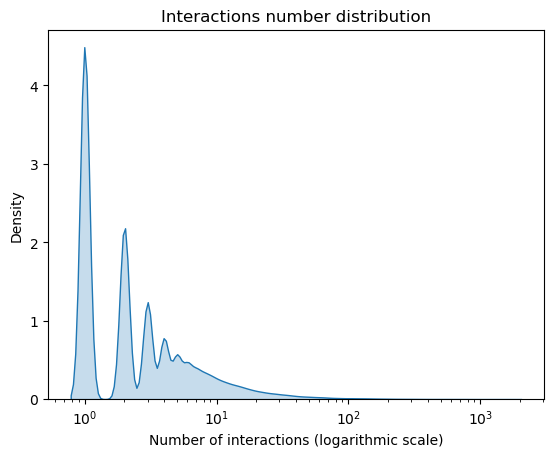

In [62]:
# Create distribution plot

sns.kdeplot(data = recipe_stats['interactions_count'], log_scale = True, fill = True, cbar = True)
plt.title('Interactions number distribution')
plt.xlabel('Number of interactions (logarithmic scale)')

In [67]:
# Print some statistical values

data = recipe_stats['interactions_count']
print('Number of recipes:', len(data))
print('Median:    ', st.median(data))
print('Quantiles: ', st.quantiles(data, n = 10))
print('Mean value:', st.mean(data))

Number of recipes: 231637
Median:     2
Quantiles:  [1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 5.0, 9.0]
Mean value: 4


After having a look at the chart above and statistical data I decided to set the first threshold as >= 10 interactions, which will cut off majority of lowest popular recipes.

In [95]:
# Cut off recipes with less than 10 interactions and check how it worked

top_rated_recipes = recipe_stats.copy()
top_rated_recipes.sort(order = 'avg_rating')
top_rated_recipes = top_rated_recipes[::-1]

print('Number of recipes included:', len(top_rated_recipes))
print('5 first elements, second column is number of interactions:')
print(top_rated_recipes[0:5])

print('\n', '*'*50, '\n')

filter_array = []
for element in top_rated_recipes:
    if element['interactions_count'] >= 10:
        filter_array.append(True)
    else:
        filter_array.append(False)
top_rated_recipes = top_rated_recipes[filter_array]
print('Number of recipes included:', len(top_rated_recipes))
print('5 first elements, second column is number of interactions:')
print(top_rated_recipes[0:5])

Number of recipes included: 231637
5 first elements, second column is number of interactions:
[(537716, 1, 5.) (537485, 1, 5.) (537459, 1, 5.) (537458, 1, 5.)
 (537242, 1, 5.)]

 ************************************************** 

Number of recipes included: 21399
5 first elements, second column is number of interactions:
[(524984, 12, 5.) (524960, 11, 5.) (524958, 13, 5.) (518202, 14, 5.)
 (518143, 13, 5.)]


As we can see, setting minimum interactions count to just 10 interactions let us filter 90% of recipes. Let's check the distribution and statistical data now:

Text(0.5, 0, 'Number of interactions (logarithmic scale)')

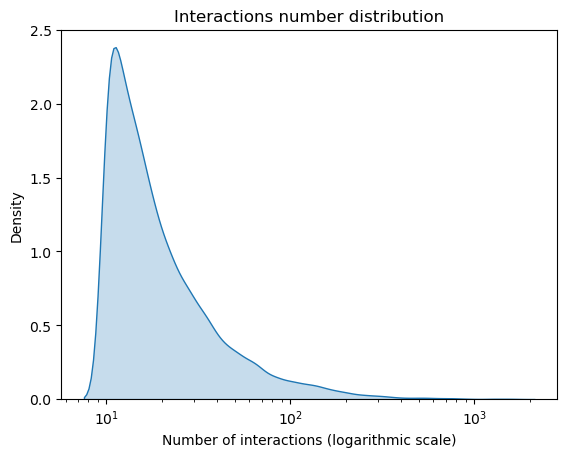

In [92]:
# Create - again - distribution plot

sns.kdeplot(data = top_rated_recipes['interactions_count'], log_scale = True, fill = True, cbar = True)
plt.title('Interactions number distribution')
plt.xlabel('Number of interactions (logarithmic scale)')

In [93]:
# Print - again - some statistical values

data = top_rated_recipes['interactions_count']
print('Number of recipes:', len(data))
print('Median:    ', st.median(data))
print('Quantiles: ', st.quantiles(data, n=10))
print('Mean value:', st.mean(data))

Number of recipes: 21399
Median:     16
Quantiles:  [10.0, 11.0, 12.0, 14.0, 16.0, 19.0, 23.0, 31.0, 50.0]
Mean value: 28


For now we can consider it as a decent outcome. Let's get our desired top recipe list!

In [94]:
# Print top rated recipes

for i in range(10, 0, -1):
    print('Position ', i, ':', sep = '')
    recipe_id = top_rated_recipes[i - 1]['recipe_id']
    name = recipes_raw.loc[recipes_raw['id'] == recipe_id]['name'].to_string(index= False)
    print(name.upper())
    print('Interactions:  ', top_rated_recipes[i - 1]['interactions_count'])
    avg_rating = top_rated_recipes[i - 1]['avg_rating']
    print(f'Average rating: {avg_rating:1.2f} / 5\n')

Position 10:
SRIRACHA HONEY ROASTED BROCCOLI
Interactions:   10
Average rating: 5.00 / 5

Position 9:
CHINESE TAKE OUT  EGG DROP SOUP
Interactions:   10
Average rating: 5.00 / 5

Position 8:
RECIPE  HOMEMADE BUTTERMILK PANCAKES
Interactions:   13
Average rating: 5.00 / 5

Position 7:
TURKEY AND VEGETABLE RAGOUT WITH WARM POLENTA R...
Interactions:   10
Average rating: 5.00 / 5

Position 6:
A 1  CHERRY COBBLER TART   A1
Interactions:   20
Average rating: 5.00 / 5

Position 5:
A1 COWBOY UP TART  A1
Interactions:   13
Average rating: 5.00 / 5

Position 4:
OPEN FACE BACON JAM AND EGG SANDWICH  A1
Interactions:   14
Average rating: 5.00 / 5

Position 3:
POLENTA CRUSTED BACON GOAT CHEESE ARROTONDARES ...
Interactions:   13
Average rating: 5.00 / 5

Position 2:
EASY CHEESY FONDUE  RAGU
Interactions:   11
Average rating: 5.00 / 5

Position 1:
SUNDAY  ANY DAY SPAGHETTI  RAGU
Interactions:   12
Average rating: 5.00 / 5



Ok, sorry for that - that's again a list of only-5-stars recipes. So let's filter it once again and check how it looks for at least 100 interactions:

<again?_again_meme>

In [96]:
# Cut off recipes with less than 100 interactions and check how it worked

print('Number of recipes included:', len(top_rated_recipes))
print('5 first elements, second column is number of interactions:')
print(top_rated_recipes[0:5])

print('\n', '*'*50, '\n')

filter_array = []
for element in top_rated_recipes:
    if element['interactions_count'] >= 100:
        filter_array.append(True)
    else:
        filter_array.append(False)
top_rated_recipes = top_rated_recipes[filter_array]
print('Number of recipes included:', len(top_rated_recipes))
print('5 first elements, second column is number of interactions:')
print(top_rated_recipes[0:5])

Number of recipes included: 21399
5 first elements, second column is number of interactions:
[(524984, 12, 5.) (524960, 11, 5.) (524958, 13, 5.) (518202, 14, 5.)
 (518143, 13, 5.)]

 ************************************************** 

Number of recipes included: 787
5 first elements, second column is number of interactions:
[(486261, 217, 4.99078341) ( 42976, 118, 4.91525424)
 ( 92072, 134, 4.86567164) (100526, 139, 4.84892086)
 (216350, 131, 4.84732824)]


Text(0.5, 0, 'Number of interactions (logarithmic scale)')

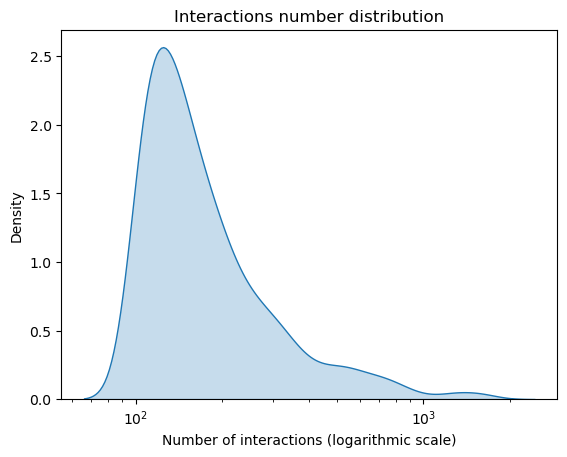

In [97]:
# Create - yes, again - distribution plot

sns.kdeplot(data = top_rated_recipes['interactions_count'], log_scale = True, fill = True, cbar = True)
plt.title('Interactions number distribution')
plt.xlabel('Number of interactions (logarithmic scale)')

In [98]:
# Print - yes, again - some statistical values

data = top_rated_recipes['interactions_count']
print('Number of recipes:', len(data))
print('Median:    ', st.median(data))
print('Quantiles: ', st.quantiles(data, n=10))
print('Mean value:', st.mean(data))

Number of recipes: 787
Median:     149
Quantiles:  [106.0, 115.0, 124.0, 136.0, 149.0, 168.0, 198.0, 246.4, 354.6]
Mean value: 209


In [99]:
# Print top rated recipes

for i in range(10, 0, -1):
    print('Position ', i, ':', sep = '')
    recipe_id = top_rated_recipes[i - 1]['recipe_id']
    name = recipes_raw.loc[recipes_raw['id'] == recipe_id]['name'].to_string(index= False)
    print(name.upper())
    print('Interactions:  ', top_rated_recipes[i - 1]['interactions_count'])
    avg_rating = top_rated_recipes[i - 1]['avg_rating']
    print(f'Average rating: {avg_rating:1.2f} / 5\n')

Position 10:
POTATO SALAD WITH CHIPOTLE PEPPERS A MAN S SALAD
Interactions:   100
Average rating: 4.82 / 5

Position 9:
EASY  FESTIVE CHOCOLATE HOLIDAY PRETZELS
Interactions:   122
Average rating: 4.84 / 5

Position 8:
CROUTONS
Interactions:   100
Average rating: 4.84 / 5

Position 7:
INDIVIDUAL CREAM CHEESE DANISH
Interactions:   135
Average rating: 4.84 / 5

Position 6:
SPICED SWEET ROASTED RED PEPPER   FETA HUMMUS
Interactions:   117
Average rating: 4.85 / 5

Position 5:
LINDA S CHEESECAKE STUFFED STRAWBERRIES
Interactions:   131
Average rating: 4.85 / 5

Position 4:
SWEET  CREAMY COLESLAW
Interactions:   139
Average rating: 4.85 / 5

Position 3:
MONTEREY CHICKEN ROLLS
Interactions:   134
Average rating: 4.87 / 5

Position 2:
BROWN SUGAR BUNDT CAKE
Interactions:   118
Average rating: 4.92 / 5

Position 1:
MEXICAN STACK UP  RSC
Interactions:   217
Average rating: 4.99 / 5



Now we got a really nice top recipes list, which means we can head to the supermarket for some tex-mex ingredients :)